### Input Example

In [1]:
from torch_geometric.data import Data
import torch

x = torch.ones(3, 30, dtype=torch.float)
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
mwt = torch.tensor([[230.]], dtype=torch.float)

dataset_input = {
    'MolToGraphFeaturizer': Data(x=x, edge_index=edge_index, batch=None), # Batch is filled when 
                                                                          # sampled from a pyg DataLoader?
    'mwt': mwt
}
dataset_input

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


{'MolToGraphFeaturizer': Data(x=[3, 30], edge_index=[2, 4]),
 'mwt': tensor([[230.]])}

### Custom Dataset

In [2]:
from typing import Union, List
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset as nnDataset
from app.features.dataset.model import Dataset
from app.features.model.schema.configs import ModelConfig

def if_str_make_list(str_or_list: Union[str, List[str]]) -> List[str]:
    if isinstance(str_or_list, str):
        return [str_or_list]
    return str_or_list

class CustomDataset(nnDataset):
    def __init__(self, dataset: Dataset, model_config: ModelConfig):
        super().__init__()
        self.dataset = dataset
        self.model_config = model_config
        self.df = dataset.get_dataframe()
        # maps featurizer name to actual featurizer instance
        self.featurizers_dict = { f.name: f.create() for f in model_config.featurizers }
        # maps featurizer name to featurizer config
        self.featurizer_configs = { f.name: f for f in model_config.featurizers }
        
    def __len__(self):
        return len(self.df)
    
    def get_not_featurized(self):
        is_col_featurized = {
            col: False 
            for col in self.model_config.dataset.feature_columns
        }
        for feat_config in self.featurizer_configs.values():
            inputs = if_str_make_list(feat_config.input)
            for input in inputs:
                is_col_featurized[input] = True
        not_featurized = [
            col
            for col, is_featurized in is_col_featurized.items()
            if not is_featurized
        ]
        return not_featurized

    def __getitem__(self, idx):
        sample = {}
        target_column = self.model_config.dataset.target_column
        y = torch.Tensor([self.df.loc[idx, [target_column]]])
        not_featurized_cols = self.get_not_featurized()
        for column in not_featurized_cols:
            # TODO, validate columns. For now assuming are all scalars
            sample[column] = torch.Tensor([self.df.loc[idx, column]])
        for feat_name, feat in self.featurizers_dict.items():
            feat_config = self.featurizer_configs[feat_name]
            inputs = if_str_make_list(feat_config.input)
            assert len(inputs) == 1, "Only featurizers with a single input for now"
            sample[feat_name] = feat(self.df.loc[idx, inputs[0]])
        
        return sample, y


## Parse model config yaml file

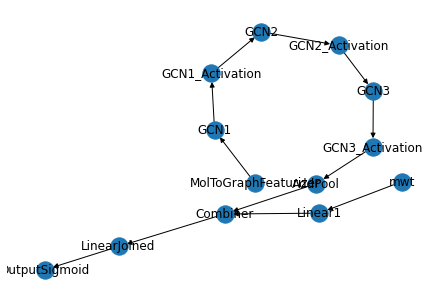

In [3]:
import networkx as nx
import yaml


config = """name: GNNExample
dataset:
  name: Small Zinc dataset
  target_column: tpsa
  feature_columns:
    - smiles
    - mwt

featurizers:
  - name: MolToGraphFeaturizer
    type: app.features.model.featurizers.MoleculeFeaturizer
    input:
      - smiles
    args:
      allow_unknown: false
      sym_bond_list: true
      per_atom_fragmentation: false

layers:

  # Start fst branch (from featurizer)
  - name: GCN1
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 26
      out_channels: 64
    input: MolToGraphFeaturizer

  - name: GCN1_Activation
    type: torch.nn.ReLU
    input: GCN1

  - name: GCN2 
    type: torch_geometric.nn.GCNConv
    input: GCN1_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN2_Activation
    type: torch.nn.ReLU
    input: GCN2

  - name: GCN3
    type: torch_geometric.nn.GCNConv
    input: GCN2_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN3_Activation
    type: torch.nn.ReLU
    input: GCN3

  - name: AddPool
    type: app.features.model.layers.GlobalPooling
    input: GCN3_Activation
    args:
      aggr: 'sum'
  # End of fst branch

  # Second branch would simply be linear layers in mwt
  - name: Linear1
    type: torch.nn.Linear
    args:
      in_features: 1
      out_features: 10
    input: mwt

  - name: Combiner
    type: app.features.model.layers.Concat
    input: ['AddPool', 'Linear1']

  - name: LinearJoined
    type: torch.nn.Linear
    input: Combiner
    args:
      in_features: 74
      out_features: 1

  - name: OutputSigmoid
    type: torch.nn.Sigmoid
    input: LinearJoined
"""

model = ModelConfig.from_yaml(config)

nx.draw(model.make_graph(), with_labels=True)

In [4]:

## Creating the database dataset object
from fastapi.datastructures import UploadFile
from app.db.session import SessionLocal
from app.features.dataset import controller as dataset_ctl
from app.features.dataset.schema import DatasetCreate, Dataset
from app.features.dataset.crud import repo as dataset_repo
from app.features.user.crud import repo as user_repo

ds_file_path = '/app/app/tests/data/zinc.csv'
ds_file = open(ds_file_path, 'rb')
ds_file = UploadFile(ds_file_path, ds_file)
user = None
db = None
if not db:
    db = SessionLocal()
ds = dataset_repo.get_by_name(db, 'Small Zinc dataset')
if not user:
    user = user_repo.get_by_email(db, email='admin@mariner.trident.bio')
    assert user is not None
if not ds:
    ds = dataset_ctl.create_dataset(db, user, DatasetCreate(
        file=ds_file,
        name="Small Zinc dataset",
        description="The dataset with 1 smiles and 1 scalar columns as features and 1 scalar column as target",
        split_target="60-20-20"
    ))
    assert ds is not None
    
# creating pygnn dataset instance
dataset = CustomDataset(ds, model)
dataloader = DataLoader(dataset)
print(next(iter(dataloader)))

/app/app/features/dataset/utils.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats = stats.append(dtypes)
/app/app/features/dataset/utils.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats = stats.append(nacount)


[{'mwt': tensor([[296.3670]]), 'MolToGraphFeaturizer': DataBatch(x=[21, 26], edge_index=[2, 42], edge_attr=[42, 9], batch=[21], ptr=[2])}, tensor([[[72.6400]]])]


In [5]:
import torch_geometric.nn as geom_nn
from torch.nn import ReLU, Sigmoid
from app.features.model.layers import GlobalPooling
from app.features.model.layers import Concat

edge_index_classes = ( geom_nn.MessagePassing )
pooling_classes = ( GlobalPooling )
activations = (ReLU, Sigmoid)

def is_message_passing(layer):
    """ x = layer(x, edge_index) """
    return isinstance(layer, geom_nn.MessagePassing)

def is_graph_pooling(layer):
    """ x = layer(x, batch) """
    return isinstance(layer, pooling_classes)

def is_concat_layer(layer):
    return isinstance(layer, Concat)

def is_graph_activation(layer, layers_dict, previous):
    """
    takes the a dictionary with nn.Modules and the keys of
    previous layers, checking if 
    """
    if not isinstance(layer, activations):
        return False
    for name in previous:
        if is_message_passing(layers_dict[name]) or is_graph_pooling(layers_dict[name]):
            return True
    return False


### Custom Model

In [19]:
from typing import Dict, Union, List
import torch
import torch.nn
from torch.optim import Adam
from torch.nn import functional as F
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data
from pytorch_lightning import LightningModule, Trainer

CustomDatasetIn = Dict[str, Union[torch.Tensor, Data]]

class CustomModel(LightningModule):

    def __init__(self, config: ModelConfig):
        super().__init__()
        
        self.config = config

        layers_dict = {}
        for layer in config.layers:
            layers_dict[layer.name] = layer.create()

        self.layers = torch.nn.ModuleDict(layers_dict)

        self.layer_configs = {
            l.name: l for l in config.layers
        }

        self.graph = config.make_graph()
        self.topo_sorting = list(nx.topological_sort(self.graph))
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        # TODO: adapt loss to problem type. MSE will only work for regression
        loss = F.mse_loss(logits, y)
        return loss
    
    def forward(self, input_: CustomDatasetIn):
        storage = input_.copy()

        for index, node_name in enumerate(self.topo_sorting):
            if not node_name in self.layers:
                continue
            layer_name = node_name
            layer = self.layers[layer_name]
            layer_config = self.layer_configs[layer_name]
            previous_layers = [p_layer for p_layer, c_layer in self.graph.in_edges(layer_name)]
            inputs = if_str_make_list(layer_config.input)
            # Step 2
            # Transform and preprocess the input and output based on the previous
            # and next layers.
            
            if is_message_passing(layer):
                assert len(inputs) == 1, f"Length of a gnn layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index = storage[src].x, storage[src].edge_index
                x, edge_index = layer(x=x, edge_index=edge_index), edge_index
                storage[layer_name] = Data(x=x, edge_index=edge_index)
            # 2.2   - if its an pooling layer it always have just one input
            #         and the input is composed by x (node_features) from the last layer
            #         and the batch that comes with the data object
            elif is_graph_pooling(layer):
                assert len(inputs) == 1, f"Length of a gnn layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index, batch = storage[src].x, storage[src].edge_index, storage[src].batch
                storage[layer_name] = layer(x=x, batch=batch)
            # 2.3   - if its an activation or a mlp/normal layer we need to check the
            #         previous layers to make sure that the input is in t;he correct format
            #         and check the next layers to format the output
            elif is_graph_activation(layer, self.layers, previous_layers):
                assert len(inputs) == 1, f"Length of a activation layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index = storage[src].x, storage[src].edge_index
                storage[layer_name] = Data(x=layer(x), edge_index=edge_index)
            elif is_concat_layer(layer):
                assert len(inputs) == 2, f"Length of a concat layer's inputs should be 2. inputs = {inputs}"
                x1, x2 = storage[inputs[0]], storage[inputs[1]]
                storage[layer_name] = layer(x1,x2)
            else:
                input_values = [ 
                    storage[input] if isinstance(storage[input], Data) else
                    storage[input]
                    for input in inputs
                ]
                storage[layer_name] = layer(*input_values)
            last = storage[layer_name]
        return last
custom_model = CustomModel(model)
x, y = next(iter(dataloader))
custom_model.forward(x)
trainer = Trainer(max_epochs=2)
trainer.fit(custom_model, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleDict | 10.1 K
--------------------------------------
10.1 K    Trainable params
0         Non-trainable params
10.1 K    Total params
0.041     Total estimated model params size (MB)
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   1%|█▋                                                                                                                        | 7/501 [00:00<00:11, 42.58it/s, loss=4.48e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:   2%|██▏                                                                                                                       | 9/501 [00:00<00:11, 42.84it/s, loss=4.37e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:   4%|████▌                                                                                                                    | 19/501 [00:00<00:09, 50.72it/s, loss=4.28e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:   4%|█████                                                                                                                    | 21/501 [00:00<00:09, 51.94it/s, loss=4.09e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:   4%|█████▎                                                                                                                    | 22/501 [00:00<00:09, 51.77it/s, loss=4.1e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:   6%|███████▍                                                                                                                 | 31/501 [00:00<00:08, 53.39it/s, loss=3.57e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:   7%|████████                                                                                                                  | 33/501 [00:00<00:08, 53.38it/s, loss=3.6e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:   7%|████████▎                                                                                                                 | 34/501 [00:00<00:08, 53.15it/s, loss=3.6e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:   8%|██████████▏                                                                                                              | 42/501 [00:00<00:08, 53.72it/s, loss=3.35e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:   9%|██████████▋                                                                                                              | 44/501 [00:00<00:08, 53.02it/s, loss=3.19e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:   9%|██████████▊                                                                                                              | 45/501 [00:00<00:08, 52.70it/s, loss=3.25e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  10%|████████████▎                                                                                                            | 51/501 [00:00<00:08, 51.21it/s, loss=3.25e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  11%|████████████▊                                                                                                            | 53/501 [00:01<00:08, 50.80it/s, loss=3.15e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  11%|█████████████                                                                                                            | 54/501 [00:01<00:08, 50.84it/s, loss=2.87e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  12%|██████████████▋                                                                                                          | 61/501 [00:01<00:08, 50.64it/s, loss=3.48e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  13%|███████████████▍                                                                                                         | 64/501 [00:01<00:08, 50.97it/s, loss=3.99e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  13%|███████████████▊                                                                                                          | 65/501 [00:01<00:08, 51.02it/s, loss=3.8e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  14%|█████████████████▍                                                                                                       | 72/501 [00:01<00:08, 50.30it/s, loss=4.57e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  15%|█████████████████▋                                                                                                       | 73/501 [00:01<00:08, 50.00it/s, loss=4.62e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  16%|███████████████████▊                                                                                                     | 82/501 [00:01<00:08, 49.76it/s, loss=4.37e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  17%|████████████████████▎                                                                                                    | 84/501 [00:01<00:08, 49.94it/s, loss=4.26e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  17%|████████████████████▊                                                                                                    | 86/501 [00:01<00:08, 49.97it/s, loss=4.28e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  19%|██████████████████████▋                                                                                                  | 94/501 [00:01<00:08, 50.55it/s, loss=3.57e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  19%|███████████████████████▏                                                                                                 | 96/501 [00:01<00:08, 50.61it/s, loss=3.64e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  19%|███████████████████████▍                                                                                                 | 97/501 [00:01<00:07, 50.56it/s, loss=3.25e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  21%|█████████████████████████▍                                                                                              | 106/501 [00:02<00:07, 51.12it/s, loss=2.73e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  22%|█████████████████████████▊                                                                                              | 108/501 [00:02<00:07, 51.35it/s, loss=2.87e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  22%|██████████████████████████▎                                                                                             | 110/501 [00:02<00:07, 51.58it/s, loss=2.94e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  24%|████████████████████████████▋                                                                                           | 120/501 [00:02<00:07, 52.54it/s, loss=2.81e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  24%|█████████████████████████████▏                                                                                          | 122/501 [00:02<00:07, 52.57it/s, loss=3.06e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  25%|█████████████████████████████▍                                                                                          | 123/501 [00:02<00:07, 52.63it/s, loss=2.95e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  27%|████████████████████████████████                                                                                         | 133/501 [00:02<00:06, 53.38it/s, loss=3.8e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  27%|████████████████████████████████▎                                                                                       | 135/501 [00:02<00:06, 53.42it/s, loss=4.17e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  27%|████████████████████████████████▌                                                                                       | 136/501 [00:02<00:06, 53.50it/s, loss=4.17e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  29%|███████████████████████████████████▏                                                                                    | 147/501 [00:02<00:06, 54.37it/s, loss=4.82e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  30%|███████████████████████████████████▍                                                                                    | 148/501 [00:02<00:06, 54.33it/s, loss=4.89e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  32%|██████████████████████████████████████▎                                                                                 | 160/501 [00:02<00:06, 54.80it/s, loss=4.24e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  32%|██████████████████████████████████████▊                                                                                 | 162/501 [00:02<00:06, 54.92it/s, loss=4.46e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  35%|█████████████████████████████████████████▍                                                                              | 173/501 [00:03<00:05, 55.35it/s, loss=3.47e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  35%|██████████████████████████████████████████▎                                                                              | 175/501 [00:03<00:05, 55.39it/s, loss=3.1e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  37%|████████████████████████████████████████████▌                                                                           | 186/501 [00:03<00:05, 55.87it/s, loss=3.11e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  38%|█████████████████████████████████████████████                                                                           | 188/501 [00:03<00:05, 55.87it/s, loss=3.59e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  40%|███████████████████████████████████████████████▉                                                                        | 200/501 [00:03<00:05, 56.55it/s, loss=4.62e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  40%|████████████████████████████████████████████████▍                                                                       | 202/501 [00:03<00:05, 56.61it/s, loss=4.36e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  43%|███████████████████████████████████████████████████                                                                     | 213/501 [00:03<00:05, 56.93it/s, loss=3.67e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  43%|███████████████████████████████████████████████████▍                                                                    | 215/501 [00:03<00:05, 56.96it/s, loss=3.55e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  45%|██████████████████████████████████████████████████████▎                                                                 | 227/501 [00:03<00:04, 57.44it/s, loss=3.88e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  46%|██████████████████████████████████████████████████████▊                                                                 | 229/501 [00:03<00:04, 57.50it/s, loss=3.75e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  48%|█████████████████████████████████████████████████████████▍                                                              | 240/501 [00:04<00:04, 57.75it/s, loss=3.47e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  49%|██████████████████████████████████████████████████████████▏                                                             | 243/501 [00:04<00:04, 57.91it/s, loss=3.23e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  51%|████████████████████████████████████████████████████████████▊                                                           | 254/501 [00:04<00:04, 58.34it/s, loss=3.08e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  51%|██████████████████████████████████████████████████████████████                                                           | 257/501 [00:04<00:04, 58.39it/s, loss=3.2e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  53%|████████████████████████████████████████████████████████████████▏                                                       | 268/501 [00:04<00:03, 58.64it/s, loss=4.29e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  54%|████████████████████████████████████████████████████████████████▉                                                       | 271/501 [00:04<00:03, 58.74it/s, loss=4.35e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  56%|███████████████████████████████████████████████████████████████████▊                                                    | 283/501 [00:04<00:03, 59.19it/s, loss=4.46e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  57%|████████████████████████████████████████████████████████████████████▎                                                   | 285/501 [00:04<00:03, 59.15it/s, loss=4.46e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  59%|██████████████████████████████████████████████████████████████████████▋                                                 | 295/501 [00:05<00:03, 58.83it/s, loss=4.01e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  59%|██████████████████████████████████████████████████████████████████████▉                                                 | 296/501 [00:05<00:03, 58.83it/s, loss=4.03e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)


Epoch 0:  62%|██████████████████████████████████████████████████████████████████████████                                              | 309/501 [00:05<00:03, 59.23it/s, loss=3.68e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 325/501 [00:05<00:02, 59.63it/s, loss=3.4e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 340/501 [00:05<00:02, 60.04it/s, loss=3.45e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  71%|█████████████████████████████████████████████████████████████████████████████████████▍                                   | 354/501 [00:05<00:02, 60.33it/s, loss=3.3e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 367/501 [00:06<00:02, 60.45it/s, loss=4.17e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 380/501 [00:06<00:01, 60.58it/s, loss=3.94e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 394/501 [00:06<00:01, 60.67it/s, loss=3.13e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 407/501 [00:06<00:01, 60.80it/s, loss=3.3e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 419/501 [00:06<00:01, 60.61it/s, loss=3.09e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 433/501 [00:07<00:01, 60.77it/s, loss=3.61e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 448/501 [00:07<00:00, 60.92it/s, loss=3.15e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 462/501 [00:07<00:00, 61.16it/s, loss=3.07e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 476/501 [00:07<00:00, 61.33it/s, loss=3.58e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 0:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 489/501 [00:07<00:00, 61.39it/s, loss=3.18e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:   0%|                                                                                                                                  | 0/501 [00:00<?, ?it/s, loss=2.83e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:   3%|███▍                                                                                                                     | 14/501 [00:00<00:07, 67.71it/s, loss=3.81e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:   6%|███████                                                                                                                  | 29/501 [00:00<00:06, 68.51it/s, loss=3.63e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:   9%|██████████▋                                                                                                              | 44/501 [00:00<00:06, 67.69it/s, loss=3.08e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  12%|██████████████                                                                                                           | 58/501 [00:00<00:06, 68.33it/s, loss=2.77e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  14%|█████████████████▍                                                                                                       | 72/501 [00:01<00:06, 68.19it/s, loss=4.74e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  17%|█████████████████████                                                                                                    | 87/501 [00:01<00:06, 68.88it/s, loss=4.33e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  20%|████████████████████████▏                                                                                               | 101/501 [00:01<00:05, 68.85it/s, loss=2.94e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  23%|███████████████████████████▌                                                                                            | 115/501 [00:01<00:05, 68.83it/s, loss=2.63e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  26%|██████████████████████████████▋                                                                                         | 128/501 [00:01<00:05, 68.22it/s, loss=3.03e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  28%|█████████████████████████████████▌                                                                                      | 140/501 [00:02<00:05, 67.06it/s, loss=4.24e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  31%|█████████████████████████████████████▏                                                                                   | 154/501 [00:02<00:05, 67.07it/s, loss=4.7e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  34%|████████████████████████████████████████▌                                                                                | 168/501 [00:02<00:04, 67.01it/s, loss=3.5e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  36%|██████████████████████████████████████████▊                                                                             | 179/501 [00:02<00:04, 66.00it/s, loss=3.44e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  38%|█████████████████████████████████████████████▌                                                                          | 190/501 [00:02<00:04, 65.10it/s, loss=4.11e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  40%|████████████████████████████████████████████████▏                                                                       | 201/501 [00:03<00:04, 64.31it/s, loss=4.44e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  43%|███████████████████████████████████████████████████▎                                                                    | 214/501 [00:03<00:04, 64.11it/s, loss=3.67e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  45%|█████████████████████████████████████████████████████▋                                                                  | 224/501 [00:03<00:04, 63.24it/s, loss=3.84e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  47%|████████████████████████████████████████████████████████▌                                                               | 236/501 [00:03<00:04, 62.90it/s, loss=3.99e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  49%|██████████████████████████████████████████████████████████▉                                                             | 246/501 [00:03<00:04, 62.18it/s, loss=3.28e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  52%|██████████████████████████████████████████████████████████████▎                                                         | 260/501 [00:04<00:03, 62.29it/s, loss=3.54e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  55%|██████████████████████████████████████████████████████████████████▋                                                      | 276/501 [00:04<00:03, 62.74it/s, loss=4.8e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  58%|█████████████████████████████████████████████████████████████████████▍                                                  | 290/501 [00:04<00:03, 62.89it/s, loss=4.01e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  60%|████████████████████████████████████████████████████████████████████████▌                                               | 303/501 [00:04<00:03, 62.86it/s, loss=3.76e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  63%|███████████████████████████████████████████████████████████████████████████▍                                            | 315/501 [00:05<00:02, 62.63it/s, loss=3.33e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 329/501 [00:05<00:02, 62.81it/s, loss=3.48e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████▊                                      | 343/501 [00:05<00:02, 62.98it/s, loss=3.5e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 357/501 [00:05<00:02, 63.12it/s, loss=2.86e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 370/501 [00:05<00:02, 63.05it/s, loss=4.41e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 384/501 [00:06<00:01, 63.25it/s, loss=3.29e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 399/501 [00:06<00:01, 63.49it/s, loss=3.15e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 413/501 [00:06<00:01, 63.62it/s, loss=3.28e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 426/501 [00:06<00:01, 63.57it/s, loss=3.32e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 438/501 [00:06<00:00, 63.43it/s, loss=3.91e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 451/501 [00:07<00:00, 63.38it/s, loss=2.9e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 465/501 [00:07<00:00, 63.52it/s, loss=3.14e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 477/501 [00:07<00:00, 63.43it/s, loss=3.69e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 492/501 [00:07<00:00, 63.50it/s, loss=2.89e+03, v_num=1]

/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:07<00:00, 63.49it/s, loss=2.83e+03, v_num=1]


/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(logits, y)
/tmp/ipykernel_1429/1862976927.py:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.S